In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [267]:
#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 700 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [229]:
#Define sets of I, J, K, where J contains I and K

# for i in range(i_num):
#     I.loc[i, 'Point number'] = 'i'+ str(i)
#     I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

# I.index = I['Point number']
    
    
# for k in range(k_num):
#     K.loc[k, 'Point number'] = 'k'+ str(k)
#     K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

# K.index = K['Point number']


# for j in range(j_num):
#     J.loc[j, 'Point number'] = 'j'+ str(j)
#     J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

# J.index = J['Point number'] 
# J = pd.concat([J, K, I], axis = 0) #Include K to J
# J

In [268]:
#Define sets of I, J, K, where J contains I and K for Passau

#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 1500 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

column_types = {
    'Name': 'str',  # Example: 'int', 'float', 'str', 'datetime64[ns]', etc.
    'Latitude': 'float',
    'Longitude': 'float',
    'Address': 'str'
    # Add more columns and their data types as needed
}

doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False, dtype=column_types)

doctors

for i in range(len(doctors['Latitude'])):
    I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
    I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
    I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

I_coordinates.index = I_coordinates['Point number']

I = I_coordinates * degree_to_m
I['Point number'] = I_coordinates['Point number']


labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False, dtype=column_types) 
labs

for k in range(len(labs['Latitude'])):
    K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
    K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
    K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

K_coordinates.index = K_coordinates['Point number']

K = K_coordinates * degree_to_m
K['Point number'] = K_coordinates['Point number']


#Define range of coordinates

combined_coordinates = pd.concat([I_coordinates, K_coordinates])

min_latitude = combined_coordinates['Latitude'].min()
max_latitude = combined_coordinates['Latitude'].max()
min_longitude = combined_coordinates['Longitude'].min()
max_longitude = combined_coordinates['Longitude'].max()

grid_spacing = 0.0018

# Create grid points
grid_points = []
for lat in np.arange(min_latitude, max_latitude + grid_spacing, grid_spacing):
    for lon in np.arange(min_longitude, max_longitude + grid_spacing, grid_spacing):
        grid_points.append((round(lat, 6), round(lon, 6)))

J_coordinates = pd.DataFrame(grid_points, columns=['Latitude', 'Longitude'])
J_coordinates['Point number'] = ['j' + str(i) for i in range(len(J_coordinates))]

J_coordinates.index = J_coordinates['Point number'] 
J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J
J_coordinates

J = J_coordinates * degree_to_m
J['Point number'] = J_coordinates['Point number']

J_coordinates

Latitude  Longitude Point number
Point number                                   
j0            48.555565  13.396102           j0
j1            48.555565  13.397902           j1
j2            48.555565  13.399702           j2
j3            48.555565  13.401502           j3
j4            48.555565  13.403302           j4
...                 ...        ...          ...
i72           48.566491  13.446163          i72
i73           48.566534   13.44633          i73
i74           48.575019  13.456904          i74
i75           48.574324   13.45916          i75
i76           48.574484  13.472108          i76

[1212 rows x 3 columns]

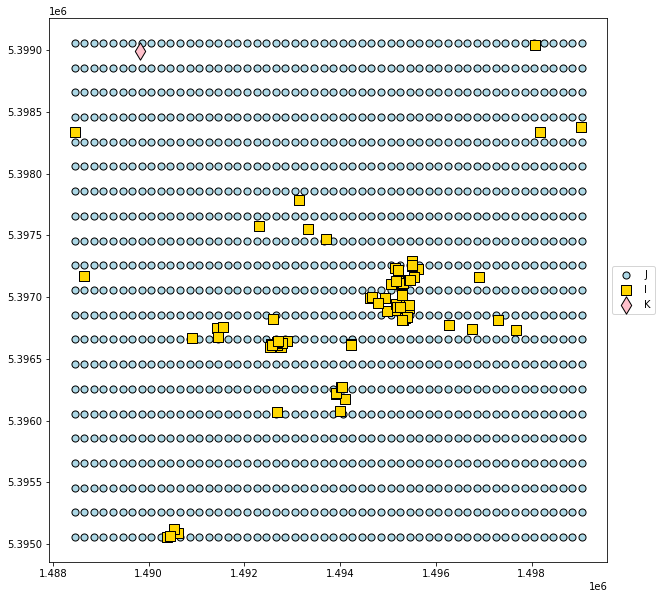

In [269]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [270]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
#%pip install folium matplotlib mapclassify
import folium
import matplotlib



with open('Polygon Passau.txt', 'r') as file:
    # Read the contents of the file into a string
    polygon_str = file.read()

# Making Passau polygon

passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

passau_poly = shapely.wkt.loads(polygon_str)
passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
folium.GeoJson(passau_gdf).add_to(passau_map)


# Assuming I_coordinates is your DataFrame with doctor coordinates
geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_doctors.iterrows():
    coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_labs.iterrows():
    coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
geo_bases = gpd.GeoDataFrame(J_coordinates, geometry=gpd.points_from_xy(J_coordinates["Latitude"], J_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_bases.iterrows():
    coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.CircleMarker([row['Latitude'], row['Longitude']],  
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



passau_map

In [285]:
#Define constants

B = 17 * (90 * 60) #battery load: meters of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 300000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

softlimit = 200
hardlimit = 10000

Deterministic model

In [272]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 6,
 'i1': 6,
 'i2': 6,
 'i3': 5,
 'i4': 1,
 'i5': 6,
 'i6': 9,
 'i7': 10,
 'i8': 4,
 'i9': 3,
 'i10': 10,
 'i11': 4,
 'i12': 2,
 'i13': 1,
 'i14': 8,
 'i15': 17,
 'i16': 0,
 'i17': 7,
 'i18': 1,
 'i19': 17,
 'i20': 5,
 'i21': 10,
 'i22': 5,
 'i23': 3,
 'i24': 4,
 'i25': 8,
 'i26': 12,
 'i27': 12,
 'i28': 6,
 'i29': 10,
 'i30': 5,
 'i31': 3,
 'i32': 6,
 'i33': 5,
 'i34': 1,
 'i35': 3,
 'i36': 4,
 'i37': 2,
 'i38': 1,
 'i39': 1,
 'i40': 10,
 'i41': 1,
 'i42': 11,
 'i43': 1,
 'i44': 1,
 'i45': 8,
 'i46': 13,
 'i47': 6,
 'i48': 3,
 'i49': 9,
 'i50': 0,
 'i51': 3,
 'i52': 7,
 'i53': 0,
 'i54': 7,
 'i55': 0,
 'i56': 11,
 'i57': 1,
 'i58': 12,
 'i59': 1,
 'i60': 4,
 'i61': 6,
 'i62': 14,
 'i63': 4,
 'i64': 6,
 'i65': 1,
 'i66': 11,
 'i67': 2,
 'i68': 6,
 'i69': 9,
 'i70': 10,
 'i71': 6,
 'i72': 4,
 'i73': 1,
 'i74': 2,
 'i75': 6,
 'i76': 10}

In [273]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 4161.767129977308,
 ('k0', 'j1'): 4100.403874253124,
 ('k0', 'j2'): 4048.001736637611,
 ('k0', 'j3'): 4004.9124868905465,
 ('k0', 'j4'): 3971.4392649873116,
 ('k0', 'j5'): 3947.826678479448,
 ('k0', 'j6'): 3934.2522759915905,
 ('k0', 'j7'): 3930.8200542604686,
 ('k0', 'j8'): 3937.556535061752,
 ('k0', 'j9'): 3954.409750473379,
 ('k0', 'j10'): 3981.2512257417548,
 ('k0', 'j11'): 4017.880785974353,
 ('k0', 'j12'): 4064.0337766969537,
 ('k0', 'j13'): 4119.390113349927,
 ('k0', 'j14'): 4183.584481493972,
 ('k0', 'j15'): 4256.2170012381475,
 ('k0', 'j16'): 4336.8637342508355,
 ('k0', 'j17'): 4425.086527661631,
 ('k0', 'j18'): 4520.441830742323,
 ('k0', 'j19'): 4622.488264231352,
 ('k0', 'j20'): 4730.792851181433,
 ('k0', 'j21'): 4844.9359220345705,
 ('k0', 'j22'): 4964.514781572716,
 ('k0', 'j23'): 5089.146272636223,
 ('k0', 'j24'): 5218.468395240016,
 ('k0', 'j25'): 5352.141145369051,
 ('k0', 'j26'): 5489.846730809899,
 ('k0', 'j27'): 5631.28930668776,
 ('k0', 'j28'): 5776.1

In [274]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [275]:
#Define set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= 0.5*B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [276]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [277]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j5'),
  ('k0', 'j6'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j10'),
  ('k0', 'j11'),
  ('k0', 'j12'),
  ('k0', 'j13'),
  ('k0', 'j14'),
  ('k0', 'j15'),
  ('k0', 'j16'),
  ('k0', 'j17'),
  ('k0', 'j18'),
  ('k0', 'j19'),
  ('k0', 'j20'),
  ('k0', 'j21'),
  ('k0', 'j22'),
  ('k0', 'j23'),
  ('k0', 'j24'),
  ('k0', 'j25'),
  ('k0', 'j26'),
  ('k0', 'j27'),
  ('k0', 'j28'),
  ('k0', 'j29'),
  ('k0', 'j30'),
  ('k0', 'j31'),
  ('k0', 'j32'),
  ('k0', 'j33'),
  ('k0', 'j34'),
  ('k0', 'j35'),
  ('k0', 'j36'),
  ('k0', 'j37'),
  ('k0', 'j38'),
  ('k0', 'j39'),
  ('k0', 'j40'),
  ('k0', 'j41'),
  ('k0', 'j42'),
  ('k0', 'j43'),
  ('k0', 'j44'),
  ('k0', 'j45'),
  ('k0', 'j46'),
  ('k0', 'j47'),
  ('k0', 'j48'),
  ('k0', 'j49'),
  ('k0', 'j50'),
  ('k0', 'j51'),
  ('k0', 'j52'),
  ('k0', 'j53'),
  ('k0', 'j59'),
  ('k0', 'j60'),
  ('k0', 'j61'),
  ('k0', 'j62'),
  ('k0', 'j63'),
  ('k0', 'j64'),
  ('k0', 'j65'),
  ('k0', 'j66'),
  ('k0', 'j67'),
  ('k0', 'j68

In [278]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [287]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [288]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [289]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
model_det.setParam('TimeLimit', hardlimit)
model_det.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 187937 rows, 94536 columns and 374124 nonzeros
Model fingerprint: 0xa817288f
Variable types: 0 continuous, 94536 integer (1212 binary)
Coefficient statistics:
  Matrix range     [3e-01, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 2.855338e+07
Presolve removed 186652 rows and 5040 columns
Presolve time: 0.81s
Presolved: 1285 rows, 89496 columns, 177780 nonzeros
Variable types: 0 continuous, 89496 integer (16924 binary)
Found heuristic solution: objective 2.585338e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.02s

Solved with pri

In [290]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, int(v.X)))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 10
0
9.35337e+06 
x_ikj[i0,k0,j636] 6
x_ikj[i1,k0,j636] 6
x_ikj[i2,k0,j636] 6
x_ikj[i3,k0,j575] 5
x_ikj[i4,k0,i5] 1
x_ikj[i5,k0,i5] 6
x_ikj[i6,k0,i5] 9
x_ikj[i7,k0,i26] 10
x_ikj[i8,k0,j572] 4
x_ikj[i9,k0,j572] 3
x_ikj[i10,k0,j572] 10
x_ikj[i11,k0,j572] 4
x_ikj[i12,k0,j572] 2
x_ikj[i13,k0,i15] 1
x_ikj[i14,k0,i21] 8
x_ikj[i15,k0,i15] 17
x_ikj[i17,k0,i58] 7
x_ikj[i18,k0,i58] 1
x_ikj[i19,k0,i19] 17
x_ikj[i20,k0,i19] 5
x_ikj[i21,k0,i21] 10
x_ikj[i22,k0,i5] 5
x_ikj[i23,k0,j572] 3
x_ikj[i24,k0,i21] 4
x_ikj[i25,k0,i15] 8
x_ikj[i26,k0,i26] 12
x_ikj[i27,k0,i5] 12
x_ikj[i28,k0,j575] 6
x_ikj[i29,k0,j575] 10
x_ikj[i30,k0,j575] 5
x_ikj[i31,k0,j575] 3
x_ikj[i32,k0,i58] 6
x_ikj[i33,k0,i15] 5
x_ikj[i34,k0,i26] 1
x_ikj[i35,k0,j575] 3
x_ikj[i36,k0,j575] 4
x_ikj[i37,k0,j575] 2
x_ikj[i38,k0,j575] 1
x_ikj[i39,k0,j636] 1
x_ikj[i40,k0,j575] 2
x_ikj[i40,k0,j636] 8
x_ikj[i41,k0,j575] 1
x_ikj[i42,k0,j572] 11
x_ikj[i43,k0,i26] 1
x_ikj[i44,k0,i19] 1
x_ikj[i45,k0,i21] 8
x_ikj[i46,k0,i19] 

In [291]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations, results_labs

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 6
 1    i1                 6
 2   i10                10
 3   i11                 4
 4   i12                 2
 ..  ...               ...
 68  i74                 2
 69  i75                 6
 70  i76                10
 71   i8                 4
 72   i9                 3
 
 [73 rows x 2 columns],
       j  Number of drones
 0   i15                50
 1   i19                50
 2   i21                50
 3   i26                50
 4    i5                50
 5   i58                37
 6  j572                50
 7  j575                49
 8  j636                50,
     k  Number of drones
 0  k0               436)

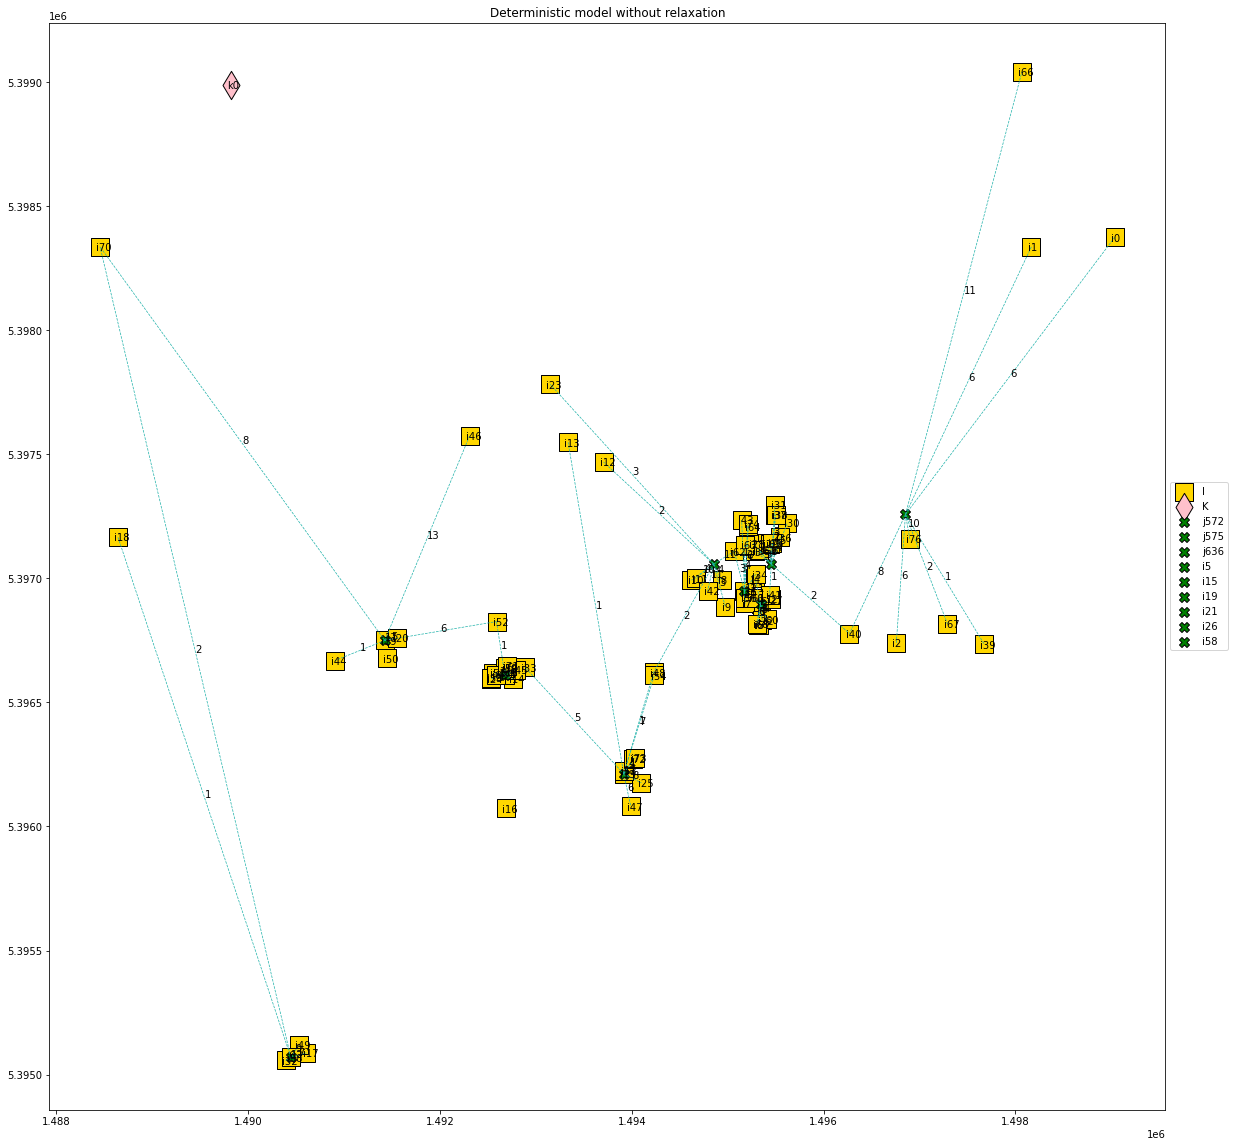

In [293]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (20, 20))
                
        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))
                
        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                # fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                #         (I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        # color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [292]:
def SolutionMap(I_coordinates, K_coordinates, J_coordinates, model):
        
        with open('Polygon Passau.txt', 'r') as file:
        # Read the contents of the file into a string
                polygon_str = file.read()

        # Making Passau polygon
        passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
        passau_poly = shapely.wkt.loads(polygon_str)
        passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
        folium.GeoJson(passau_gdf).add_to(passau_map)

        # Assuming I_coordinates is your DataFrame with doctor coordinates
        geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326") 
        
        indices_xi = []
        indices_y = pd.DataFrame(columns = ['Location name', 'Latitude', 'Longitude'])
        indices_x = pd.DataFrame(columns = ['I', 'J', 'Number of drones'])
        
        
        i = 0
        for v in model.getVars():
                if v.x > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_xi = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                indices_x.loc[i, 'I'] = str(indices_xi[0])
                                indices_x.loc[i, 'J'] = str(indices_xi[2])
                                indices_x.loc[i, 'Number of drones'] = int(v.x)
                                i += 1
                                
                        else:
                                y_name = v.varName[4:-1]
                                indices_y.loc[str(y_name), 'Latitude'] = J_coordinates.loc[str(y_name), 'Latitude']
                                indices_y.loc[str(y_name), 'Longitude'] = J_coordinates.loc[str(y_name), 'Longitude']
                                # 
                                # fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                #         edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                        
        geo_solution_y = gpd.GeoDataFrame(indices_y, geometry=gpd.points_from_xy(indices_y["Latitude"], indices_y["Longitude"]), crs="epsg:4326")
        
        
        
        for idx, row in geo_doctors.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                        icon=folium.Icon(icon='circle', prefix='fa', color='orange', size = 0.1), 
                        popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
                
        
        
        for idx, row in geo_solution_y.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                        icon=folium.Icon(icon='circle', prefix='fa', color='green', size = 0.1), 
                        popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

        for idx, row in geo_labs.iterrows():
                coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
                folium.Marker([row['Latitude'], row['Longitude']], 
                                icon=folium.Icon(icon='circle', prefix='fa', color='red'), size = 0.1, 
                                popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
        
        
        for idx, row in indices_x.iterrows():
                point_i = I_coordinates.loc[row['I'], ['Latitude', 'Longitude']]
                point_j = J_coordinates.loc[row['J'], ['Latitude', 'Longitude']]
                folium.PolyLine(locations=[(point_i['Latitude'], point_i['Longitude']), 
                                        (point_j['Latitude'], point_j['Longitude'])], color='blue').add_to(passau_map)
                
                label = str(row['Number of drones'])  # Just the number of drones without additional text
                folium.Marker([(point_i['Latitude'] + point_j['Latitude']) / 2, 
                        (point_i['Longitude'] + point_j['Longitude']) / 2], 
                      icon=folium.DivIcon(html=f"<div style='background-color: white; border-radius: 50%; padding: 5px;'><div style='font-size: 10pt; color: {'blue'};'>{label}</div></div>")).add_to(passau_map)
        

        return passau_map


SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_det)

Probabilistic model

In [248]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 5

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [249]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [250]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [251]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [252]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [253]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 433501 rows, 219286 columns and 11611249 nonzeros
Model fingerprint: 0x2ff9c8f6
Variable types: 0 continuous, 219286 integer (5072 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 8e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.527789e+07
Presolve removed 430644 rows and 28219 columns (presolve time = 5s) ...
Presolve removed 430644 rows and 28219 columns
Presolve time: 5.91s
Presolved: 2857 rows, 191067 columns, 379425 nonzeros
Variable types: 0 continuous, 191067 integer (2782 binar

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.callbackstub'
Traceback (most recent call last):
  File "src\gurobipy\callback.pxi", line 209, in gurobipy.CallbackClass.callback
  File "C:\Users\AleksandraPetrenko\AppData\Local\Temp\ipykernel_40908\3340277974.py", line 3, in softtime
KeyboardInterrupt: 


  5388  5115 1.8220e+07 1209  100 1.8478e+07 1.8220e+07  1.40%   6.0  371s
  5411  5136 1.8220e+07   15  123 1.8478e+07 1.8220e+07  1.40%  12.7  375s
  5416  5139 1.8220e+07   16  123 1.8478e+07 1.8220e+07  1.40%  12.7  425s
  5442  5186 1.8220e+07   19  123 1.8478e+07 1.8220e+07  1.40%  12.8  430s
  5476  5252 1.8220e+07   24  125 1.8478e+07 1.8220e+07  1.40%  12.8  436s
  5553  5393 1.8220e+07   35  116 1.8478e+07 1.8220e+07  1.40%  12.9  449s
  5720  5661 1.8220e+07   49   86 1.8478e+07 1.8220e+07  1.40%  13.3  466s
  6044  5834 1.8220e+07  100   85 1.8478e+07 1.8220e+07  1.40%  14.2  480s
  6325  6019 1.8220e+07  142   29 1.8478e+07 1.8220e+07  1.40%  15.3  493s
  6603  6139 1.8220e+07  177   29 1.8478e+07 1.8220e+07  1.40%  16.5  524s
  6816  6445 1.8220e+07  199   28 1.8478e+07 1.8220e+07  1.40%  17.2  539s
  7193  6502 1.8220e+07  280   35 1.8478e+07 1.8220e+07  1.40%  18.1  587s
  7376  6548 1.8220e+07  351   20 1.8478e+07 1.8220e+07  1.40%  18.3  650s

Cutting planes:
  Lift-a

In [ ]:
ListSolution(model_prob)

Number of solutions found: 9
0
1.84779e+07 
x_ikj[i0,k0,i1] 17
x_ikj[i1,k0,i1] 9
x_ikj[i2,k0,i28] 11
x_ikj[i2,k0,i31] 2
x_ikj[i3,k0,i23] 9
x_ikj[i4,k0,i62] 3
x_ikj[i5,k0,i26] 12
x_ikj[i6,k0,i11] 9
x_ikj[i6,k0,i13] 7
x_ikj[i7,k0,i12] 8
x_ikj[i7,k0,i13] 6
x_ikj[i8,k0,i12] 17
x_ikj[i9,k0,i11] 10
x_ikj[i10,k0,i13] 2
x_ikj[i10,k0,i46] 14
x_ikj[i11,k0,i11] 14
x_ikj[i12,k0,i12] 5
x_ikj[i13,k0,i13] 7
x_ikj[i14,k0,i59] 13
x_ikj[i15,k0,i15] 20
x_ikj[i17,k0,i49] 16
x_ikj[i18,k0,k0] 5
x_ikj[i19,k0,i19] 17
x_ikj[i20,k0,i19] 10
x_ikj[i21,k0,i51] 12
x_ikj[i21,k0,i59] 4
x_ikj[i22,k0,i13] 9
x_ikj[i22,k0,i26] 4
x_ikj[i23,k0,i23] 9
x_ikj[i24,k0,i19] 4
x_ikj[i24,k0,i51] 13
x_ikj[i25,k0,i15] 17
x_ikj[i26,k0,i26] 20
x_ikj[i27,k0,i12] 6
x_ikj[i27,k0,i23] 4
x_ikj[i27,k0,i62] 10
x_ikj[i28,k0,i28] 17
x_ikj[i29,k0,i23] 6
x_ikj[i29,k0,i43] 11
x_ikj[i30,k0,i31] 12
x_ikj[i31,k0,i31] 10
x_ikj[i32,k0,k0] 8
x_ikj[i32,k0,i49] 4
x_ikj[i33,k0,i52] 14
x_ikj[i34,k0,i62] 5
x_ikj[i35,k0,i28] 12
x_ikj[i36,k0,i23] 9
x_ikj[i37,

In [ ]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                17
 1    i1                 9
 2   i10                16
 3   i11                14
 4   i12                 5
 ..  ...               ...
 70  i74                 7
 71  i75                10
 72  i76                14
 73   i8                17
 74   i9                10
 
 [75 rows x 2 columns],
       j  Number of drones
 0    i1                26
 1   i11                50
 2   i12                50
 3   i13                50
 4   i15                50
 5   i19                31
 6   i23                50
 7   i26                50
 8   i28                50
 9   i31                50
 10  i43                50
 11  i46                50
 12  i49                50
 13  i51                50
 14  i52                50
 15  i59                50
 16  i62                50
 17   k0                50,
     k  Number of drones
 0  k0               857)

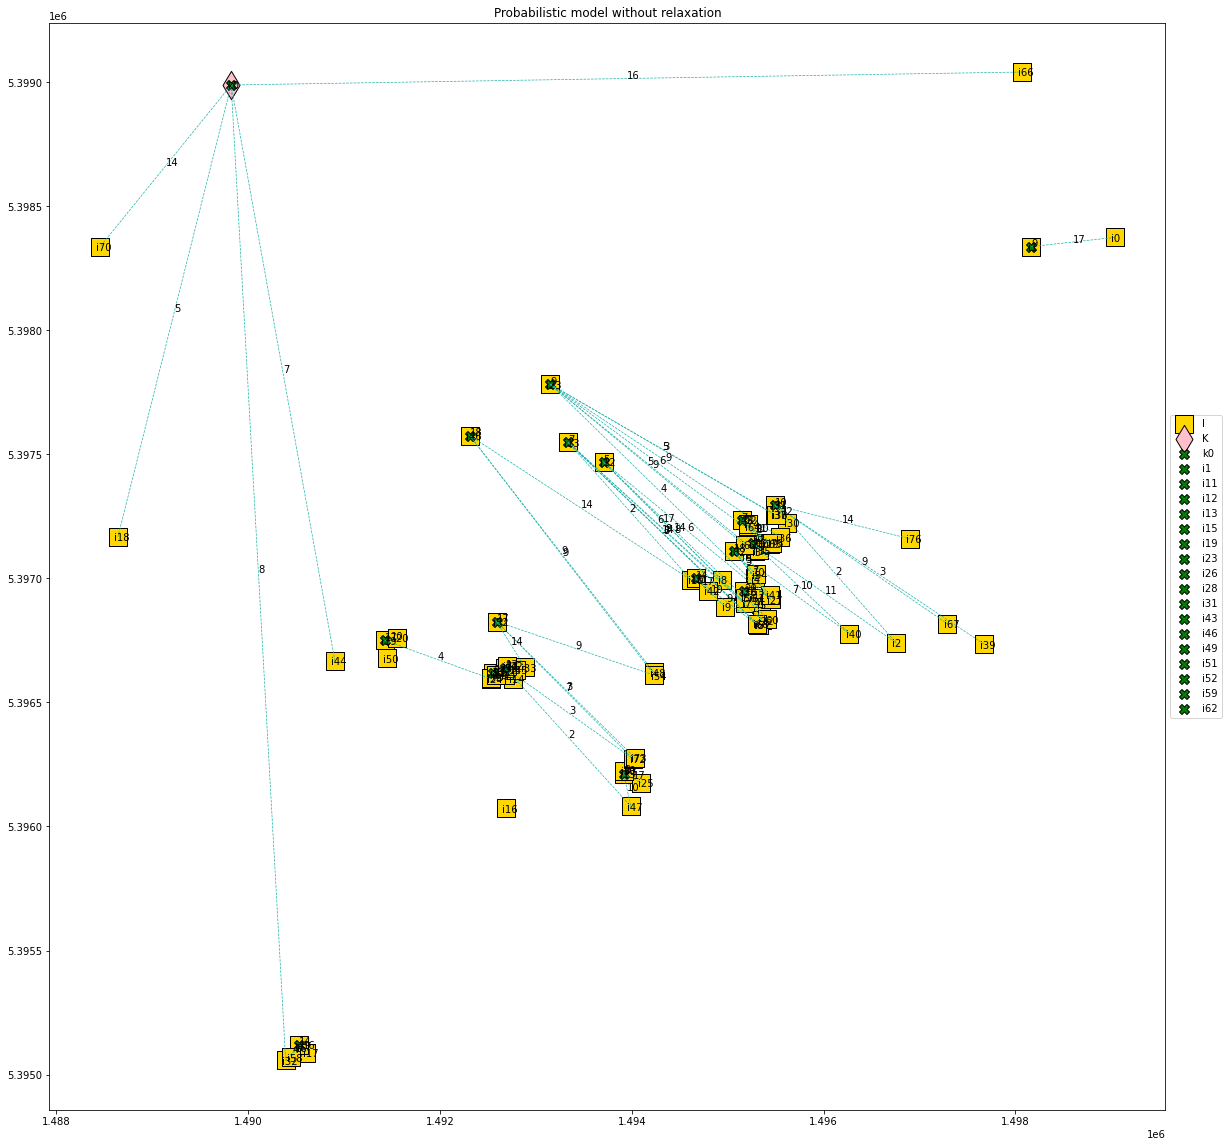

In [ ]:
SolutionGraph(I, K, J, model_prob)

In [ ]:
SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob)

Probabilistic model with relaxed constraints

In [ ]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [ ]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [ ]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [ ]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [ ]:
# #Redefine constants and random variables


# I_feasG = []
# for i in I_feas:
#     for g in range(1, g_i[i] + 1):
#         I_feasG.append((i, g))

In [ ]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [ ]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [ ]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 190151 rows, 96826 columns and 8294959 nonzeros
Model fingerprint: 0xc254097f
Variable types: 0 continuous, 96826 integer (3502 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 8e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 4.267787e+07
Presolve removed 186649 rows and 4903 columns (presolve time = 5s) ...
Presolve removed 188864 rows and 4903 columns
Presolve time: 5.86s
Presolved: 1287 rows, 91923 columns, 182707 nonzeros
Variable types: 0 continuous, 91923 integer (1212 binary)
Foun

In [ ]:
ListSolution(model_prob_rel)

Number of solutions found: 9
0
1.84779e+07 
x_ikj[i0,k0,i1] 17
x_ikj[i1,k0,i1] 9
x_ikj[i2,k0,i28] 11
x_ikj[i2,k0,i31] 2
x_ikj[i3,k0,i23] 9
x_ikj[i4,k0,i62] 3
x_ikj[i5,k0,i26] 12
x_ikj[i6,k0,i11] 9
x_ikj[i6,k0,i13] 7
x_ikj[i7,k0,i12] 8
x_ikj[i7,k0,i13] 6
x_ikj[i8,k0,i12] 17
x_ikj[i9,k0,i11] 10
x_ikj[i10,k0,i13] 2
x_ikj[i10,k0,i46] 14
x_ikj[i11,k0,i11] 14
x_ikj[i12,k0,i12] 5


x_ikj[i13,k0,i13] 7
x_ikj[i14,k0,i59] 13
x_ikj[i15,k0,i15] 20
x_ikj[i17,k0,i49] 16
x_ikj[i18,k0,k0] 5
x_ikj[i19,k0,i19] 17
x_ikj[i20,k0,i19] 10
x_ikj[i21,k0,i51] 12
x_ikj[i21,k0,i59] 4
x_ikj[i22,k0,i13] 9
x_ikj[i22,k0,i26] 4
x_ikj[i23,k0,i23] 9
x_ikj[i24,k0,i19] 4
x_ikj[i24,k0,i51] 13
x_ikj[i25,k0,i15] 17
x_ikj[i26,k0,i26] 20
x_ikj[i27,k0,i12] 6
x_ikj[i27,k0,i23] 4
x_ikj[i27,k0,i62] 10
x_ikj[i28,k0,i28] 17
x_ikj[i29,k0,i23] 6
x_ikj[i29,k0,i43] 11
x_ikj[i30,k0,i31] 12
x_ikj[i31,k0,i31] 10
x_ikj[i32,k0,k0] 8
x_ikj[i32,k0,i49] 4
x_ikj[i33,k0,i52] 14
x_ikj[i34,k0,i62] 5
x_ikj[i35,k0,i28] 12
x_ikj[i36,k0,i23] 9
x_ikj[i37,k0,i23] 5
x_ikj[i38,k0,i23] 3
x_ikj[i39,k0,i31] 3
x_ikj[i40,k0,i28] 10
x_ikj[i40,k0,i62] 7
x_ikj[i41,k0,i62] 7
x_ikj[i42,k0,i11] 17
x_ikj[i43,k0,i43] 7
x_ikj[i44,k0,k0] 7
x_ikj[i45,k0,i59] 12
x_ikj[i46,k0,i46] 18
x_ikj[i47,k0,i15] 10
x_ikj[i47,k0,i59] 2
x_ikj[i48,k0,i46] 9
x_ikj[i49,k0,i49] 14
x_ikj[i51,k0,i51] 9
x_ikj[i52,k0,i52] 17
x_ikj[i53,k0,i15] 3
x_ikj[i54,k0,i46] 9


In [ ]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                17
 1    i1                 9
 2   i10                16
 3   i11                14
 4   i12                 5
 ..  ...               ...
 70  i74                 7
 71  i75                10
 72  i76                14
 73   i8                17
 74   i9                10
 
 [75 rows x 2 columns],
       j  Number of drones
 0    i1                26
 1   i11                50
 2   i12                50
 3   i13                50
 4   i15                50
 5   i19                31
 6   i23                50
 7   i26                50
 8   i28                50
 9   i31                50
 10  i43                50
 11  i46                50
 12  i49                50
 13  i51                50
 14  i52                50
 15  i59                50
 16  i62                50
 17   k0                50,
     k  Number of drones
 0  k0               857)

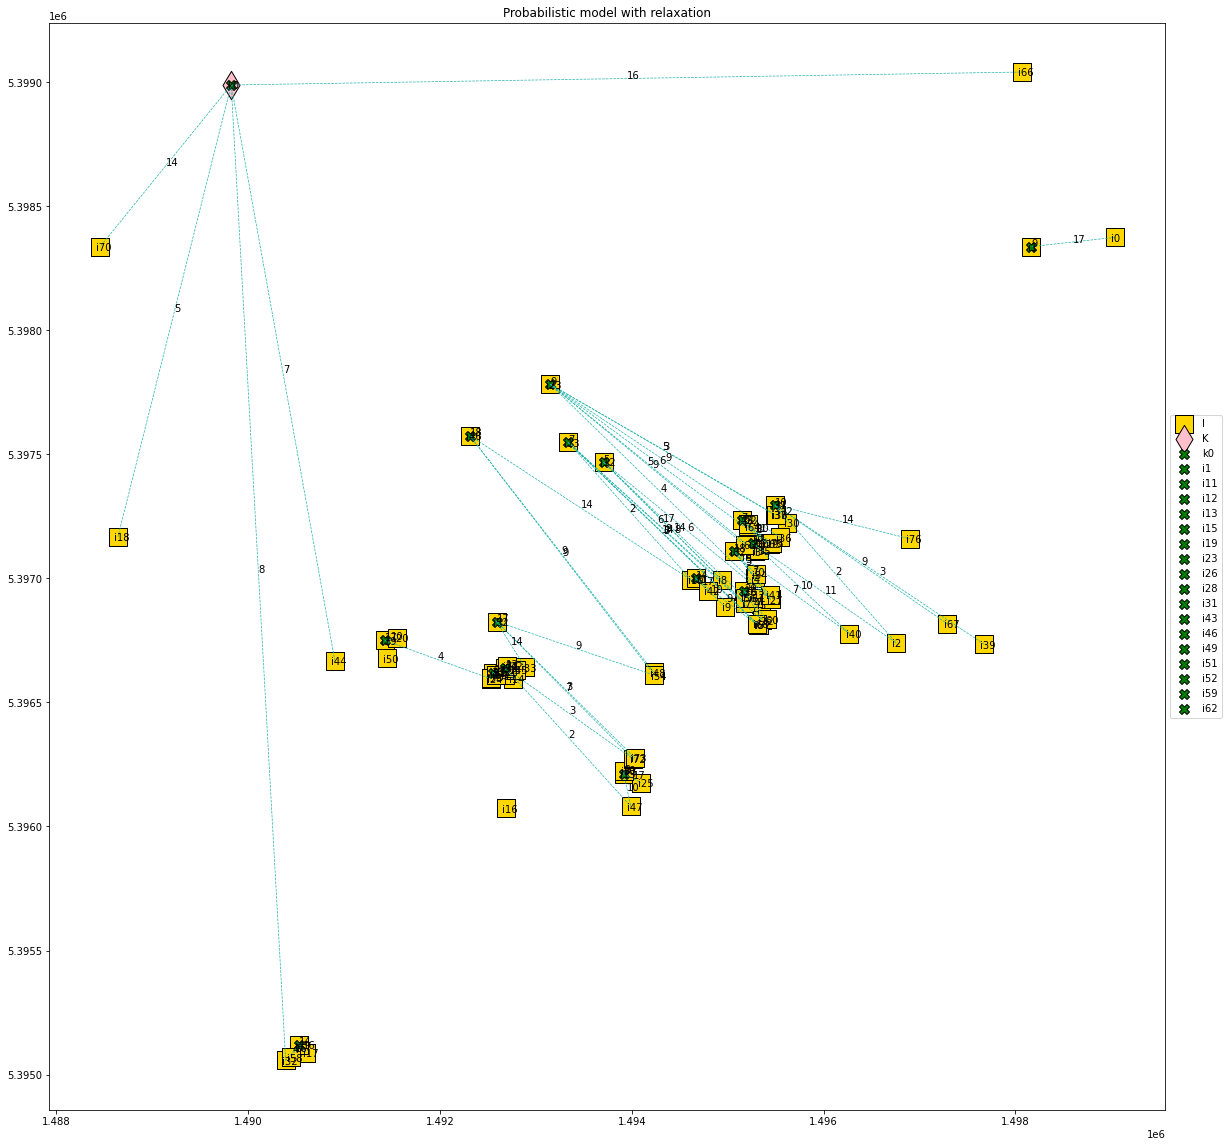

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

In [ ]:
SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

Deterministic model with relaxed constraints

In [ ]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [ ]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [ ]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 187937 rows, 94536 columns and 374128 nonzeros
Model fingerprint: 0x9ad4ac4e
Variable types: 0 continuous, 94536 integer (1212 binary)
Coefficient statistics:
  Matrix range     [3e-01, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 3.502645e+07
Presolve removed 186654 rows and 7462 columns
Presolve time: 1.36s
Presolved: 1283 rows, 87074 columns, 172936 nonzeros
Variable types: 0 continuous, 87074 integer (8440 binary)
Found heuristic solution: objective 3.342645e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with prim

In [ ]:
ListSolution(model_det_rel)

Number of solutions found: 8
0
1.01264e+07 
x_ikj[i0,k0,k0] 7
x_ikj[i1,k0,k0] 1
x_ikj[i1,k0,i23] 2
x_ikj[i2,k0,i43] 11
x_ikj[i3,k0,i23] 7
x_ikj[i4,k0,i12] 2


x_ikj[i5,k0,i8] 4
x_ikj[i6,k0,i13] 8
x_ikj[i7,k0,i8] 4
x_ikj[i8,k0,i8] 13
x_ikj[i9,k0,i46] 6
x_ikj[i10,k0,i46] 10
x_ikj[i11,k0,i13] 9
x_ikj[i12,k0,i12] 1
x_ikj[i13,k0,i13] 2
x_ikj[i14,k0,i51] 1
x_ikj[i14,k0,i52] 6
x_ikj[i15,k0,i52] 9
x_ikj[i17,k0,i49] 10
x_ikj[i18,k0,k0] 1
x_ikj[i19,k0,k0] 9
x_ikj[i20,k0,k0] 7
x_ikj[i21,k0,i51] 12
x_ikj[i22,k0,i8] 7
x_ikj[i23,k0,i23] 4
x_ikj[i24,k0,i51] 10
x_ikj[i25,k0,i46] 10
x_ikj[i26,k0,i8] 5
x_ikj[i26,k0,i12] 4
x_ikj[i26,k0,i13] 9
x_ikj[i27,k0,i12] 11
x_ikj[i27,k0,i13] 1
x_ikj[i28,k0,i23] 4
x_ikj[i29,k0,i43] 11
x_ikj[i30,k0,i23] 2
x_ikj[i31,k0,i23] 7
x_ikj[i32,k0,i49] 5
x_ikj[i33,k0,i52] 8
x_ikj[i34,k0,i12] 1
x_ikj[i35,k0,i23] 8
x_ikj[i36,k0,i43] 2
x_ikj[i37,k0,i23] 2
x_ikj[i39,k0,i43] 3
x_ikj[i40,k0,i12] 13
x_ikj[i41,k0,i12] 8
x_ikj[i42,k0,i13] 12
x_ikj[i42,k0,i46] 1
x_ikj[i43,k0,i43] 2
x_ikj[i44,k0,k0] 2
x_ikj[i45,k0,i52] 4
x_ikj[i46,k0,i46] 7
x_ikj[i47,k0,i52] 6
x_ikj[i48,k0,i46] 1
x_ikj[i49,k0,i49] 8
x_ikj[i51,k0,i51] 3
x_ikj[i52,k0,i52] 6
x_i

In [ ]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 7
 1    i1                 3
 2   i10                10
 3   i11                 9
 4   i12                 1
 ..  ...               ...
 66  i74                 3
 67  i75                 4
 68  i76                 6
 69   i8                13
 70   i9                 6
 
 [71 rows x 2 columns],
      j  Number of drones
 0  i12                50
 1  i13                50
 2  i23                50
 3  i43                50
 4  i46                50
 5  i49                31
 6  i51                36
 7  i52                50
 8   i8                50
 9   k0                50,
     k  Number of drones
 0  k0               467)

In [ ]:
SolutionMap(I_coordinates, K_coordinates, J_coordinates, model_prob_rel)

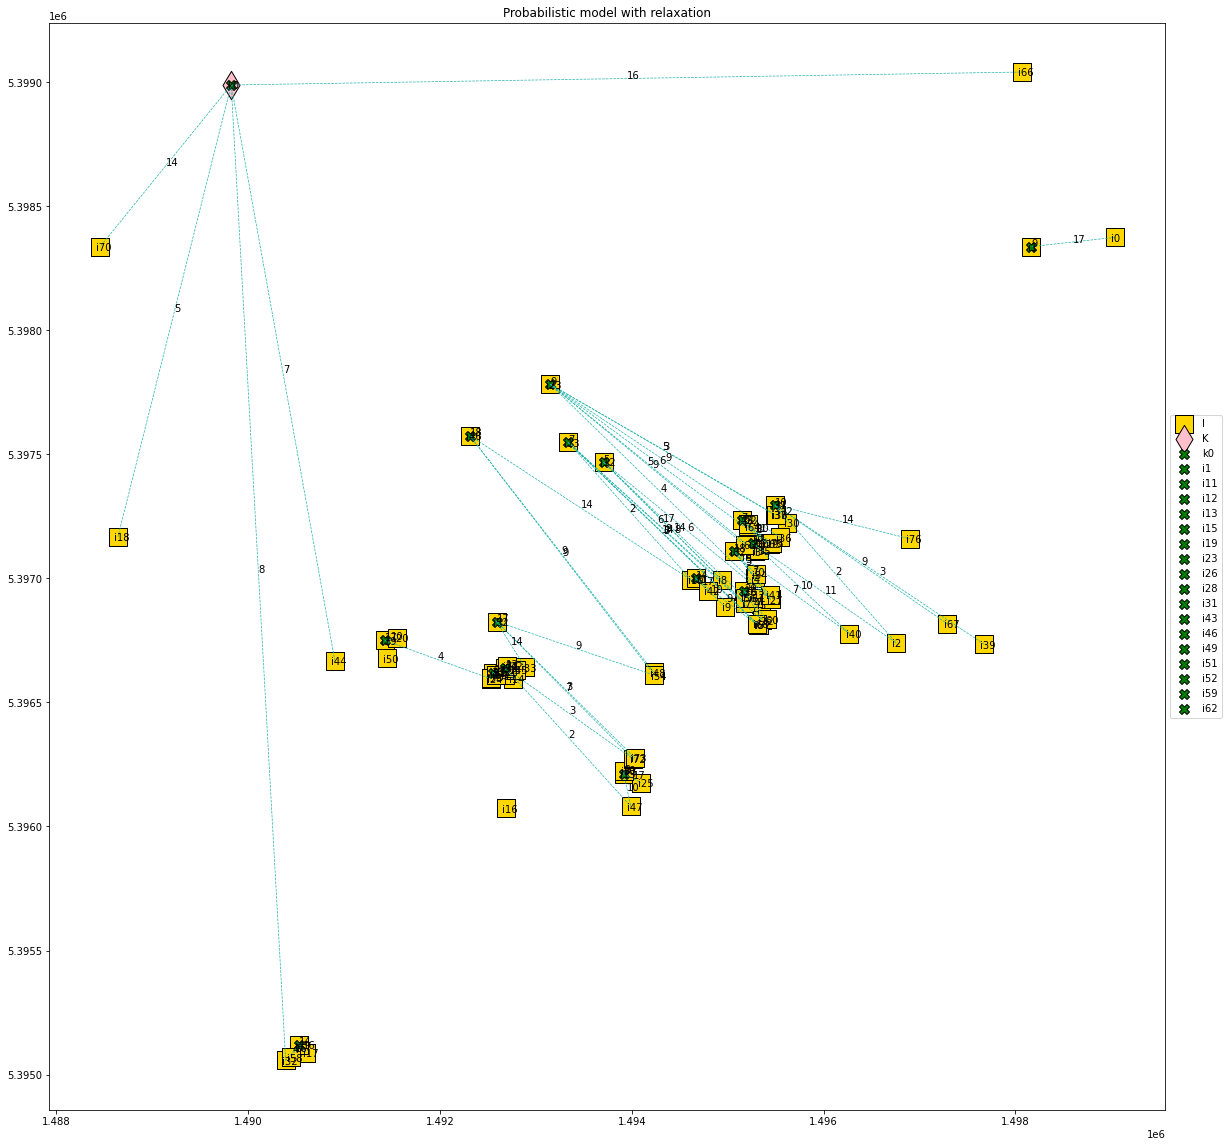

In [ ]:
SolutionGraph(I, K, J, model_prob_rel)

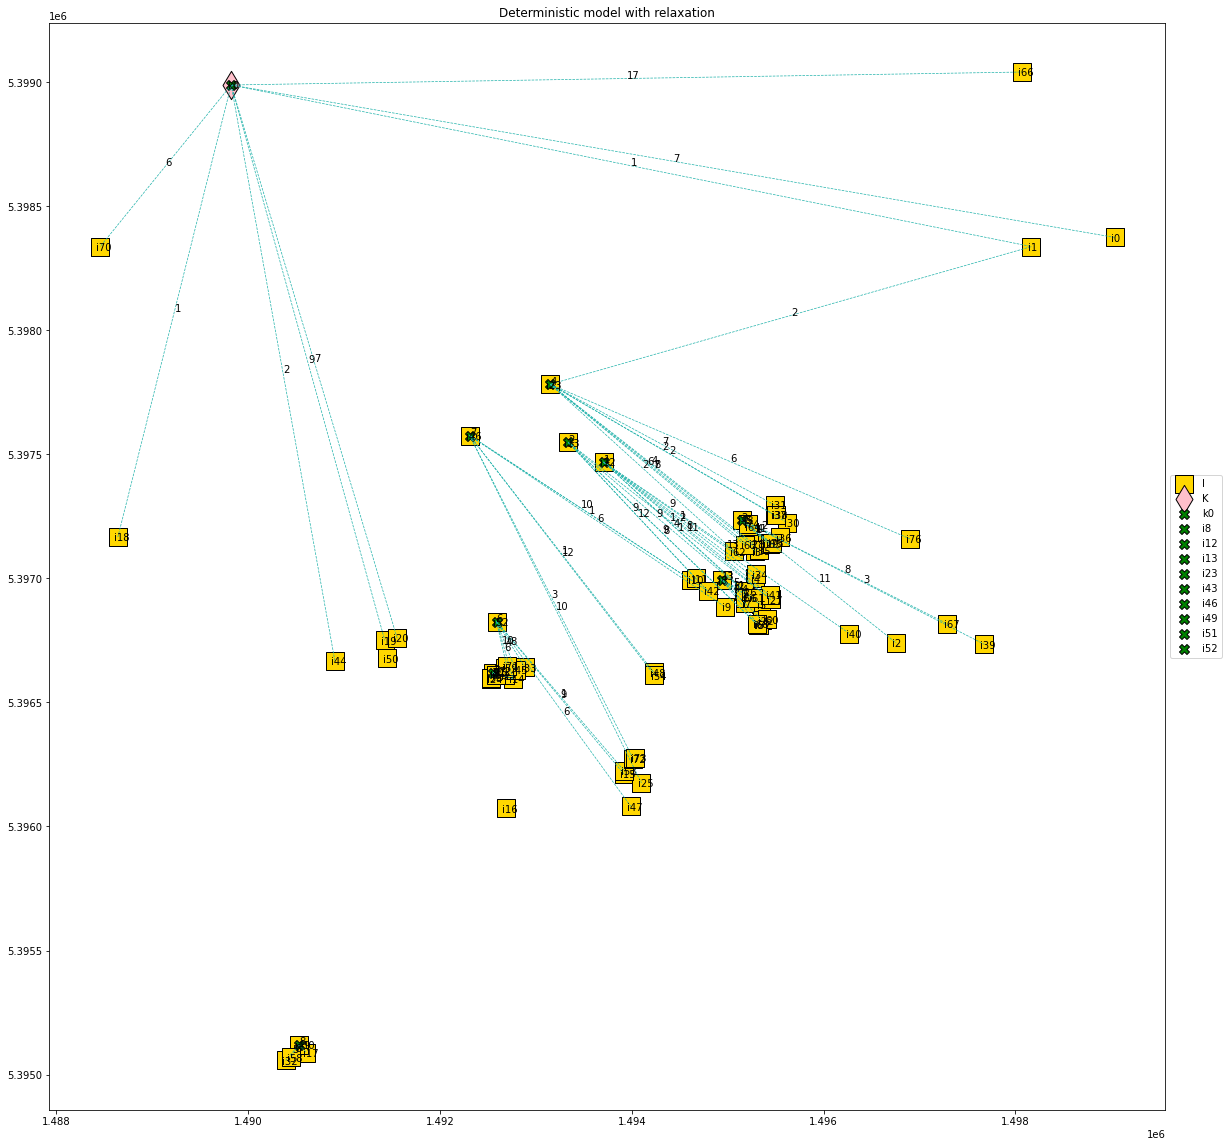

In [ ]:
SolutionGraph(I, K, J, model_det_rel)

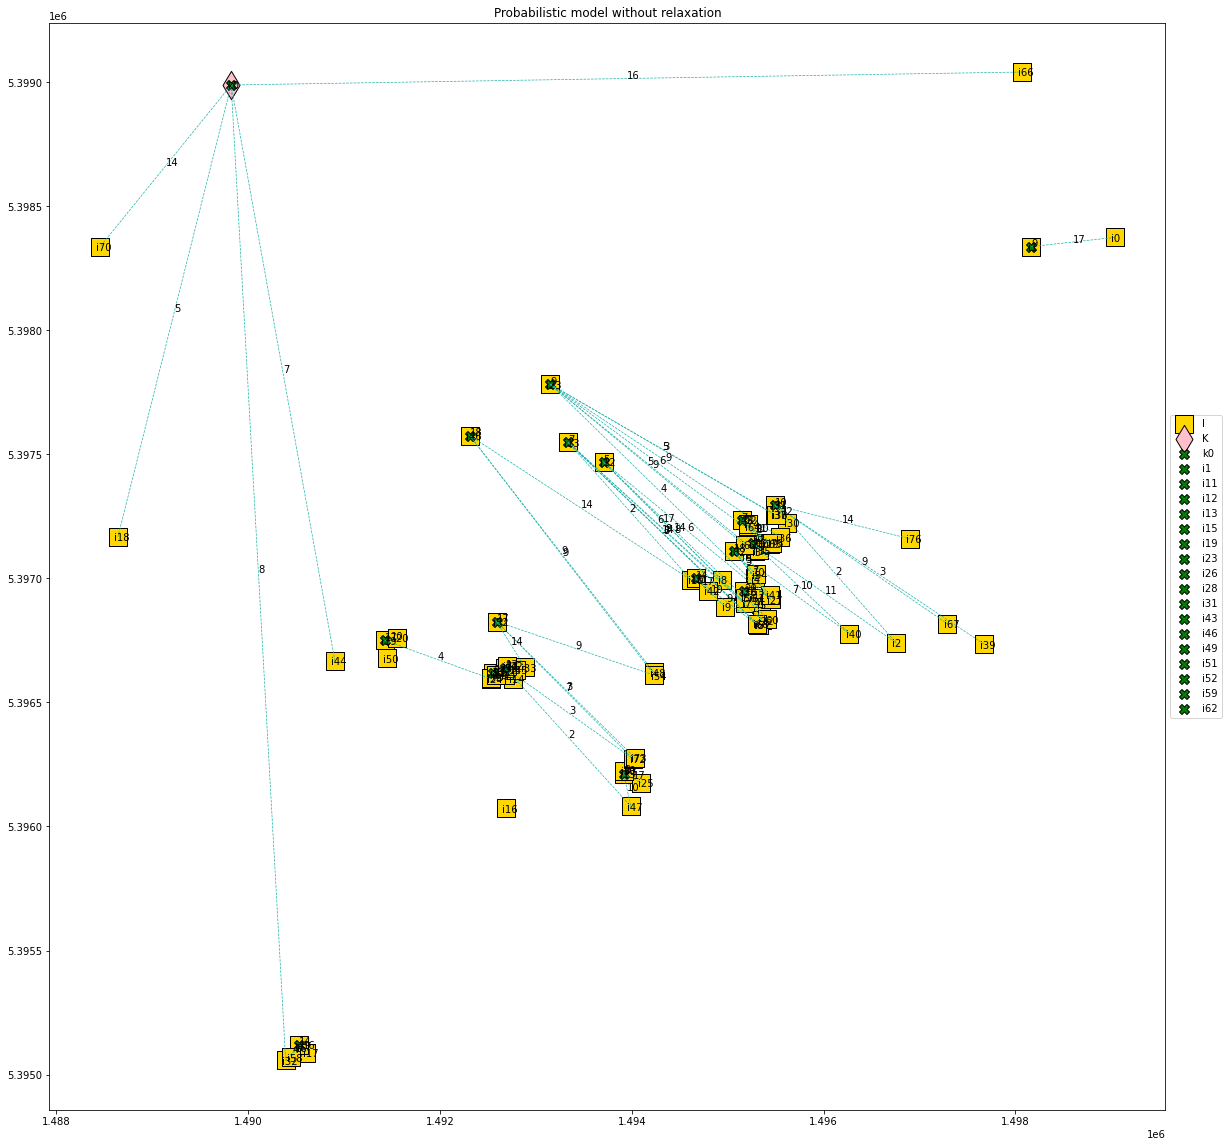

In [ ]:
SolutionGraph(I, K, J, model_prob)

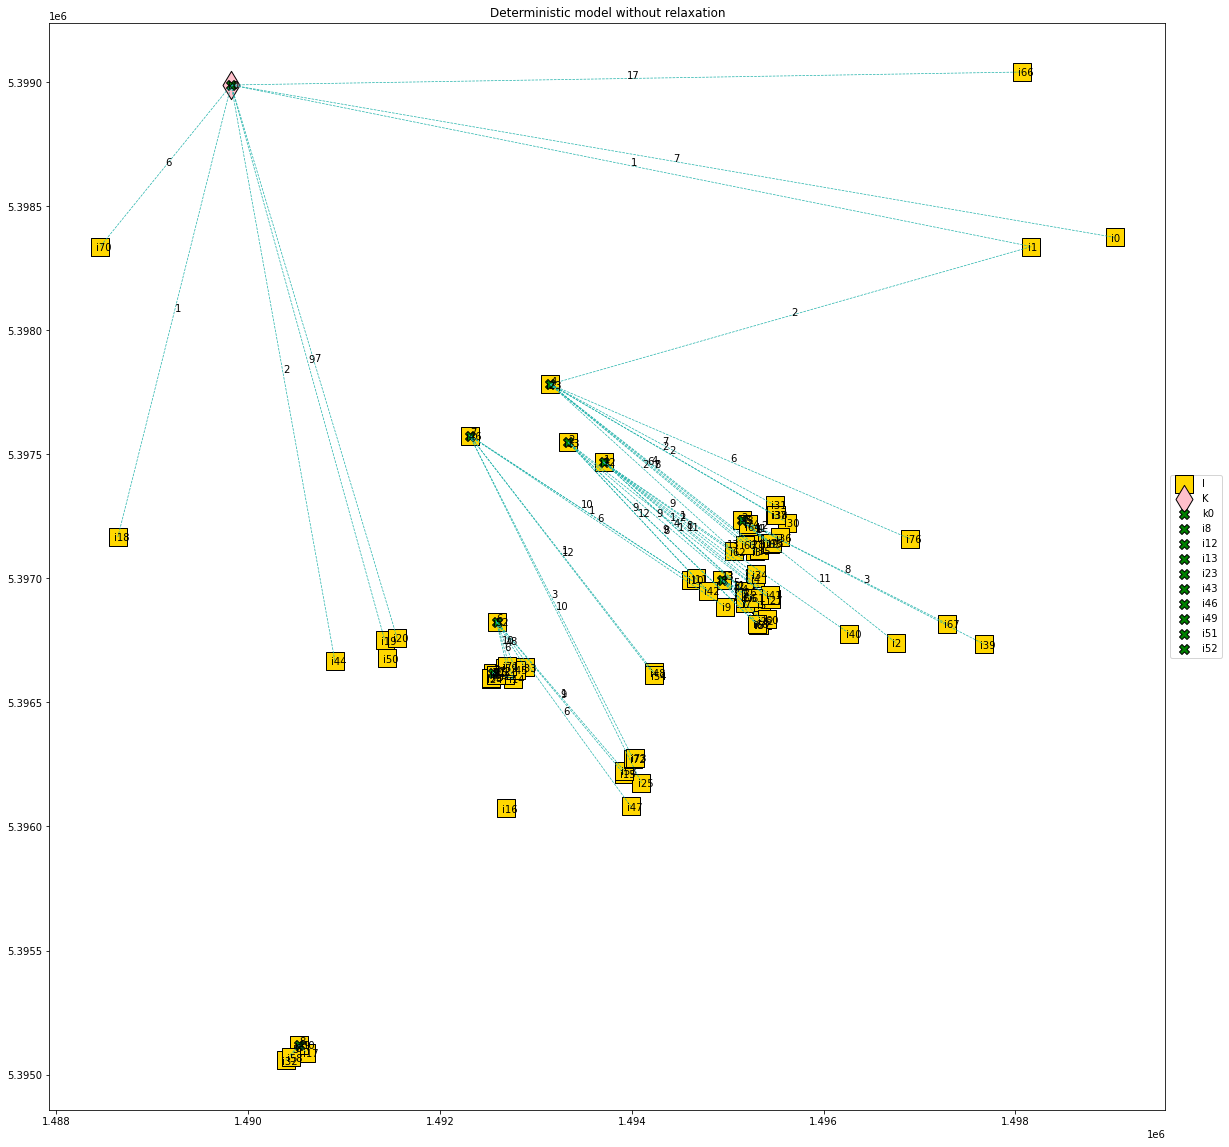

In [ ]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty